Min Train Loss: 2.667498
Min Validation Loss: 2.9469
Max Hellaswag eval: 0.3364


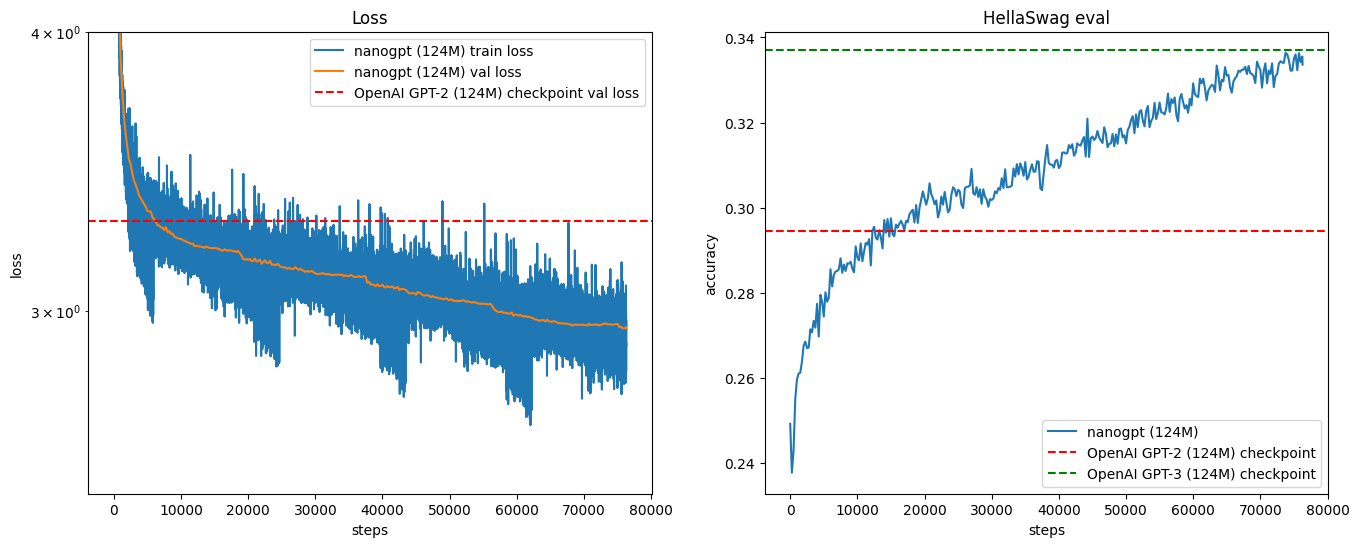

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))


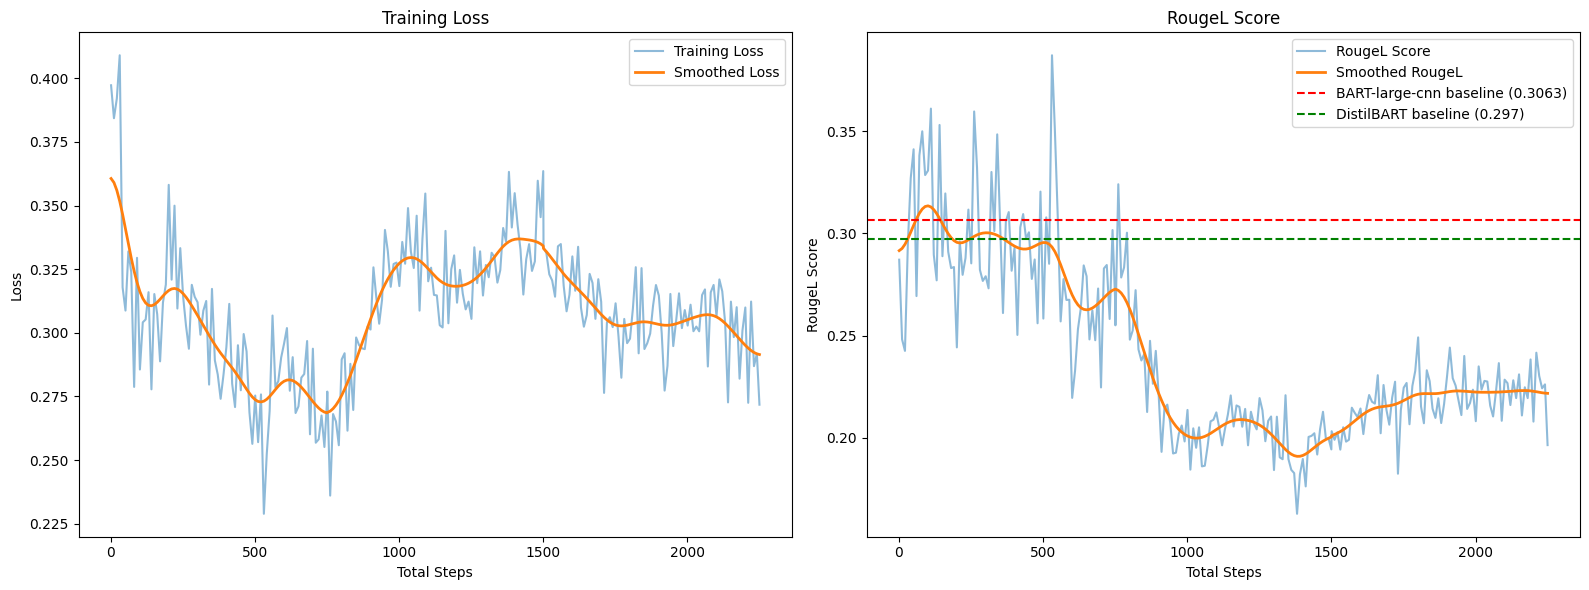

Min Loss: 0.2289 at step 531
Max RougeL: 0.3871 at step 531
Final Loss: 0.2718
Final RougeL: 0.1964


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

%matplotlib inline

# RougeL baseline values
rougeL_baseline_bart = 30.63 * 0.01
rougeL_baseline_distilbart = 29.70 * 0.01

# Parse the log file
total_steps = []
losses = []
rougeLs = []

with open("log/log_ce.txt", "r") as f:
    for line in f:
        parts = line.strip().split('|')
        # Parse step information (E1/3 S1/750)
        step_part = parts[0].strip().split()
        epoch_info = step_part[0]  # E1/3
        batch_info = step_part[1]  # S1/750
        
        # Extract epoch number (the number after E)
        epoch_num = int(epoch_info.split('/')[0][1:])
        # Extract batch number (the number after S)
        batch_num = int(batch_info.split('/')[0][1:])
        
        # Calculate total step (0-based)
        total_step = (epoch_num - 1) * 750 + batch_num
        
        # Parse loss
        loss = float(parts[1].strip().split()[1])
        
        # Parse rougeL (last metric in the line)
        rougeL = float(parts[-1].strip().split()[-1])
        
        total_steps.append(total_step)
        losses.append(loss)
        rougeLs.append(rougeL)

# Convert to numpy arrays for easier manipulation
total_steps = np.array(total_steps)
losses = np.array(losses)
rougeLs = np.array(rougeLs)

# Create figure with two subplots
plt.figure(figsize=(16, 6))

# Panel 1: Loss
plt.subplot(121)
plt.plot(total_steps, losses, 'C0', label='Training Loss', alpha=0.5)
# Add smoothed line (using Gaussian filter)
sigma = 5  # Smoothing factor - adjust as needed
smoothed_loss = gaussian_filter1d(losses, sigma)
plt.plot(total_steps, smoothed_loss, 'C1', label='Smoothed Loss', linewidth=2)
plt.xlabel("Total Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")

# Panel 2: RougeL
plt.subplot(122)
plt.plot(total_steps, rougeLs, 'C0', label='RougeL Score', alpha=0.5)
# Add smoothed line
smoothed_rouge = gaussian_filter1d(rougeLs, sigma)
plt.plot(total_steps, smoothed_rouge, 'C1', label='Smoothed RougeL', linewidth=2)
# Add baseline lines
plt.axhline(y=rougeL_baseline_bart, color='r', linestyle='--', 
            label=f'BART-large-cnn baseline ({rougeL_baseline_bart})')
plt.axhline(y=rougeL_baseline_distilbart, color='g', linestyle='--', 
            label=f'DistilBART baseline ({rougeL_baseline_distilbart})')
plt.xlabel("Total Steps")
plt.ylabel("RougeL Score")
plt.legend()
plt.title("RougeL Score")

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Min Loss: {min(losses):.4f} at step {total_steps[np.argmin(losses)]}")
print(f"Max RougeL: {max(rougeLs):.4f} at step {total_steps[np.argmax(rougeLs)]}")
print(f"Final Loss: {losses[-1]:.4f}")
print(f"Final RougeL: {rougeLs[-1]:.4f}")